# MAPD B Project: ***Batch analysis of cosmic rays using Drift Tubes detectors***

- **Goal**: The goal of this project is to analyze real data collected in a particle physics detector to reconstruct the trajectory of muons from cosmic rays.



**Students:**
- Ada D'Iorio      (**ID**: 2092320, **e-mail**: ada.diorio@studenti.unipd.it)
- Mandana Goudarzi (**ID**: 2122279, **e-mail**: mandana.goudarzi@studenti.unipd.it)
- Dario Liotta     (**ID**: 2212429, **e-mail**: dario.liotta.1@studenti.unipd.it)

# Introduction

A set of muon detectors have been built and installed in Legnaro INFN Laboratories (∼10 km far from Padova) and are currently used to collect signals from cosmic rays. The working principles of these detectors (named mini Drift Tubes or miniDTs) are based on ionization: charged particles traversing the volume of the detectors will ionize the gas mixture inside, thus producing electron-ion pairs. Specifically shaped electric fields make the electron cloud travel throughout the volume with an almost constant drift velocity ($v_{drift} = 53.8 \ \mu m/ns$). Near the sensing anode wire, the electric field intensifies, leading to additional ionization and avalanche effects, thereby amplifying the signal.

Signals generated by ionization events are collected on the anodic wire, then amplified, digitized, discriminated, and transmitted through a Data Acquisition (DAQ) system.

Within the DAQ system, a series of Field Programmable Gate Arrays (FPGAs) perform Time-to-Digital Conversion (TDC), associating a digital signal with each electron cloud based on the time of collection.
Each digitized signal is commonly referred to as a "hit" representing an ionization event within the detector.

<div style="text-align: center;">
    <img src="muon-cell-schema.png" alt="Muon cell schema" width="500">
</div>

If the time of passage of the muon (usually referred to as $t_0$) is known, the TDC of a hit can be translated to a position inside the cell thanks to the constant $v_{drift}$, i.e:

$$ x_{hit} = (t_{hit}-t_0)v_{drift} $$

The time of passage of the muon is typically not known a priori and needs to be inferred from external information or geometrical considerations.
Additionally, there is an intrinsic left-right ambiguity associated with the time-to-space
conversion process. This means that the time information of a single hit is insufficient to
determine whether the muon passed through the right or left half of the cell.
To resolve this ambiguity and accurately reconstruct the trajectory of the muon, a full reconstruction of the track spanning multiple cells is required. By analyzing hits from multiple cells, it becomes possible to identify the track trajectory throughout one or more DT chambers and resolve the left-right ambiguity.




The geometry of one single detector (a miniDT “chamber”) is composed of 64 cells arranged in 4 layers of 16 cells each. Adjacent layers are staggered by half of a cell width.

Each cell has a transversal dimension of $42\times13 \ mm^2$ (width × height). The schema for one DT chamber is reported in the following figure:

<div style="text-align: center;">
    <img src="chamber-schema.png" alt="Chamber schema" width="1000">
</div>

Four DT chambers are stacked on top of each other in a "muon-telescope" configuration.

Three chambers (0, 2, 3) are oriented in the same direction, while the fourth (1) is rotated $90$ degrees to measure from an orthogonal view. Two external detectors (plastic scintillator palettes, shown in blue in the figure) provide the external timing information for the passage of particles, hence supplying the $t_0$ information.

## Task

Starting from the raw data collected by the DAQ of the detector, this project will require reconstructing the local and global track, relying on the external timing reference provided by the scintillator.

## Data structure

The raw dataset is provided on a cloud storage s3 bucket hosted on Cloud Veneto.
Name of the Bucket: mapd-minidt-batch
Link to visualize the list all contained files: https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/mapd-minidt-batch/

The dataset is composed of multiple binary files encoding the stream of hits collected:
1. Every hit is encoded as a 64 bit word;
2. Each word has the exact same structure;
3. The 64b data-format complies to the following standard:
- $0-4$   (5 bits)  $\rightarrow$ `TDC`;
- $5-16$  (12 bits) $\rightarrow$ `BX`;
- $17-48$ (32 bits) $\rightarrow$ `ORBIT`;
- $49-57$ (9 bits)  $\rightarrow$ `CHAN`;
- $58-60$ (3 bits)  $\rightarrow$ `FPGA`;
- $61-63$ (3 bits)  $\rightarrow$ `HEAD`.

The data should be "unpacked" from raw objects into a structured format (dataframe).

# Requirements

## Libraries

In [1]:
## Standard python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import struct
import collections
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba

## PySpark library
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf, explode, count, first, pandas_udf, PandasUDFType
from pyspark.sql.functions import abs as abs_spark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, FloatType, DoubleType, ArrayType
from pyspark.sql import functions as F
import configparser

## Spark session

In [2]:
config = configparser.ConfigParser()
config.read('./aws_credentials.txt')
access_key = config.get('DEFAULT', 'access_key')
secret_key = config.get('DEFAULT', 'secret_key')

spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("MAPD B Project")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.4')\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')\
    .config("spark.executor.cores", 4)\
    .config("spark.executor.memory", "3500m")\
    .config("spark.sql.shuffle.partitions", 24)\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', str(access_key))\
    .config('spark.hadoop.fs.s3a.secret.key', str(secret_key))\
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()


# Creating a spark context
sc = spark.sparkContext  


:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/liotta/.ivy2/cache
The jars for the packages stored in: /home/liotta/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3718ac5b-8626-4ecd-95b9-7401e42e4c93;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 160ms :: artifacts dl 6ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------

# Data import and inspection

## Data unpacking and conversion

We want to convert the raw object in binary form contained into the files in a structured form (a dataframe).

In [3]:
def unpack_data(data):
  word_format = 'Q'
  word = struct.unpack(word_format, data)[0]
    
  TDC   = word         & 0x1F
  BX    = (word >> 5)  & 0xFFF
  ORBIT = (word >> 17) & 0xFFFFFFFF
  CHAN  = (word >> 49) & 0x1FF
  FPGA  = (word >> 58) & 0x7
  HEAD  = (word >> 61) & 0x7
    
  return [TDC, BX, ORBIT, CHAN, FPGA, HEAD]



rdd = sc.binaryRecords('s3a://mapd-minidt-batch/data_*.dat', 8)
rdd2 = rdd.map(unpack_data)

df = rdd2.toDF(["TDC", "BX", "ORBIT", "CHAN", "FPGA", "HEAD"])

24/07/07 21:52:18 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [4]:
df.show(10)

+---+----+----------+----+----+----+
|TDC|  BX|     ORBIT|CHAN|FPGA|HEAD|
+---+----+----------+----+----+----+
|  0|   0|4079645633| 100|   1|   1|
|  2|4064|4079645602| 100|   1|   0|
| 23|1476|4079645568| 100|   1|   4|
| 16| 653|4079645568| 100|   1|   5|
|  2|2922|3387200947|  75|   0|   2|
| 29|2227|3387200955| 105|   0|   2|
|  7|2234|3387200955| 107|   0|   2|
| 29| 476|3387200973| 126|   0|   2|
| 12|1797|3387200955|  55|   1|   2|
| 28|2165|3387200956|  36|   1|   2|
+---+----+----------+----+----+----+
only showing top 10 rows



## Dataset cleansing

We know that every entry beside the ones where `HEAD = 2` must be dropped.

In [5]:
df = df.filter(col("HEAD") == 2)
df = df.drop("HEAD")

df.show(10)

+---+----+----------+----+----+
|TDC|  BX|     ORBIT|CHAN|FPGA|
+---+----+----------+----+----+
|  2|2922|3387200947|  75|   0|
| 29|2227|3387200955| 105|   0|
|  7|2234|3387200955| 107|   0|
| 29| 476|3387200973| 126|   0|
| 12|1797|3387200955|  55|   1|
| 28|2165|3387200956|  36|   1|
| 14| 249|3387200970|  51|   1|
| 28| 475|3387200973|  90|   1|
| 16| 485|3387200973| 124|   0|
|  5| 480|3387200973| 127|   0|
+---+----+----------+----+----+
only showing top 10 rows



We now verify if there is some datum that is not in the range we expect (so `FPGA` values different from $0$ and $1$ and `CHAN` values not in the $[0,128]$ range).

In [6]:
df_not_in_range = df.filter((col('CHAN') > 128) | (col('FPGA') > 1))

df_not_in_range.groupBy('FPGA').count().show()
df_not_in_range.groupBy('CHAN').count().show()

+----+------+
|FPGA| count|
+----+------+
|   1|304521|
|   0|209373|
+----+------+



+----+------+
|CHAN| count|
+----+------+
| 138|513894|
+----+------+



We can observe that there are some outsiders inside the `CHAN` attribute, all equal to $138$, that we can drop.

In [7]:
df = df.filter(col('CHAN') != 138)

## Muon passages

We know that muon passages are associated with attributes `CHAN = 128` and simultaneously `FPGA = 1`, so we create another attribute named `SCINT` which is equal to $1$ when these conditions are satisfied and equal to $0$ when they are not, which tells us if the scintillator has revealed the passage of a muon.



In [8]:
df = df.withColumn('SCINT', when((col('CHAN') == 128) & (col('FPGA') == 1), 1).otherwise(0))

Having itentified the scintillation events, we now choose to persist our dataframe in memory, since its size ($848.1 \ MB$) should fit inside the memory of the executors, in order to speed up computations.

In [9]:
df = df.persist()
df.count() #To trigger persist

99909874

Having the scintillator information, we can now count how many scintillation events are there per orbit. Hence, we inspect the number of hits and the number of scintillator hits for each orbit.

In [10]:
n_hits = df.groupby('ORBIT')\
           .count()\
           .toPandas()
data_counts = df.groupby('ORBIT')\
                .agg(F.sum('SCINT').alias('n_scint'))\
                .toPandas()

24/07/07 21:54:08 ERROR TaskSchedulerImpl: Lost executor 0 on 10.67.22.62: Command exited with code 137
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_43 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_24 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_34 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_26 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_54 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_16 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_32 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_65 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_23_70 !
24/07/07 21:54:08 WARN BlockManagerMasterEndpoint:

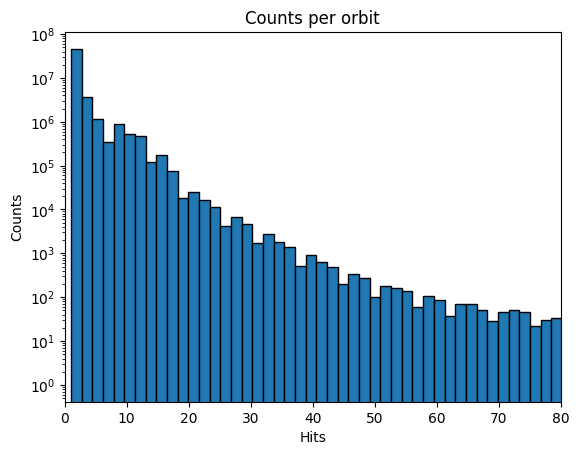

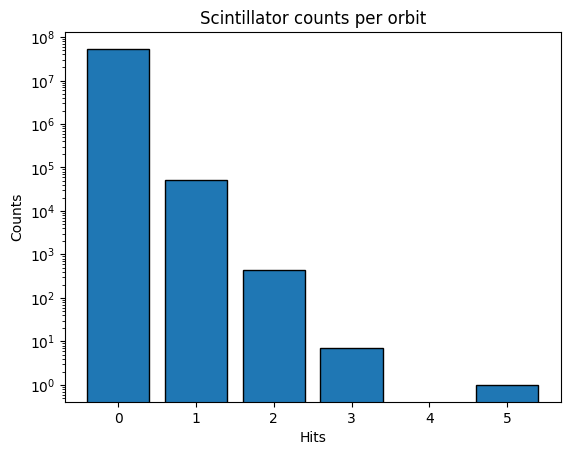

In [11]:
# Counts per orbit
plt.hist(n_hits['count'], bins = 500, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.title('Counts per orbit')
plt.xlim(0, 80)
plt.yscale('log')
plt.show()

# Scintillator counts per orbit
counts = data_counts['n_scint'].value_counts().sort_index()
plt.bar(counts.index, counts.values, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.title('Scintillator counts per orbit')
plt.yscale('log')
plt.show()

Unfortunately, as it is possible to observe from the second plot, there is a lot of noise given by the passage of muons or other particles that haven't travelled inside the scintillators. In order to be able to detect the tracks of the particle and analyze them, we need to further filter the data. We choose to only consider orbits in which only one scintillation event has been registered, for two reasons:

* Hits inside orbits where no scintillator hit has been measured cannot be associated to a muon passage
* Hits inside orbits with two or more scintillator hits cannot be definitively attributed to a single muon event, as it is not possible to distinguish to which muon passage each hit belongs.
  
In order to achieve this, we group on the orbits that present one and only one signal from the scintillator in the same orbit. We are looking for something of the form:
 
```python
        TDC	  BX	    ORBIT     CHAN      FPGA  SCINT
4	2	2922     3387200947	75	  0     0
5	29	2227     3387200955	128	  1     1    # <- there is a count from the scintillator
6	7	2234     3387200955	107	  0     0    # <- in the same orbit there is also another count
7	29	476      3387200973	126	  0     0

```

In [12]:
orbits_w_scint = df.filter(col('SCINT') == 1).select('ORBIT') 
repeated_orbits = orbits_w_scint.groupBy('ORBIT').count().filter(col('count') > 1).select('ORBIT')

df = df.join(orbits_w_scint, 'ORBIT', 'inner')
df = df.join(repeated_orbits, 'ORBIT', 'left_anti')

We now repeat the same histogram seen above that shows the number of hits per orbit, having filtered the dataset.

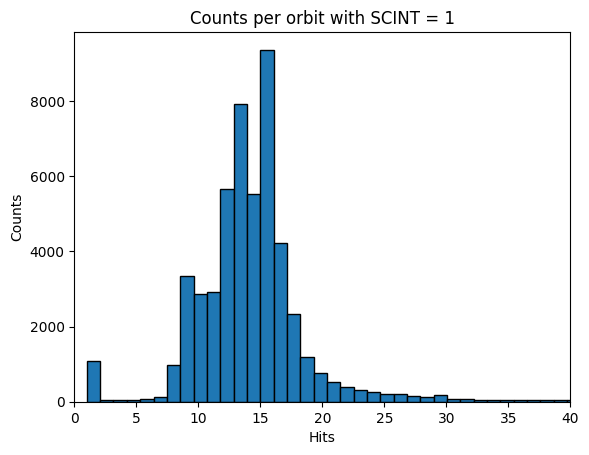

In [13]:
n_hits = df.groupBy('ORBIT')\
           .count()\
           .toPandas()

plt.hist(n_hits["count"], bins = 250, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.xlim(0, 40)
plt.title('Counts per orbit with SCINT = 1')
plt.show()

Another problem that should be addressed regards the number of hits registered for each orbit. A muon travelling inside the detector is going to trigger at most $16$ channels, given the geometry of the problem. An orbit with a number of channels bigger than $16$ means that various phenomena could have happened: multiple scattering inside the detector, multiple particles arriving in coincidence in the apparatus and so on.

We now ask ourselves: is there a way to further investigate for noise, i. e. drop off hits we know for sure are not related to any muon passage? The answer is yes, but we need to evaluate time information associated with hits.

## Spatial prospective

In this section we are interested in an analysis of the spatial distribution of the muons before starting to reconstruct the tracks. From the `CHAN` column of the dataframe, it is possible to reconstruct the chamber that actually collected the hit. Another function, `identify_layer()`, is able to distinguish the layer that contains the drift tube that actually collected the muon. By convention, we choose $-1$ as a value in scint cases in both `CHAMBER` and `LAYER` attribute.

In [14]:
# Chamber information
df = df.withColumn('CHAMBER',
                   when((col('FPGA') == 0) & (col('CHAN') >= 0) & (col('CHAN') <= 63), 0)
                   .when((col('FPGA') == 0) & (col('CHAN') >= 64) & (col('CHAN') <= 127), 1)
                   .when((col('FPGA') == 1) & (col('CHAN') >= 0) & (col('CHAN') <= 63), 2)
                   .when((col('FPGA') == 1) & (col('CHAN') >= 64) & (col('CHAN') <= 127), 3)
                   .otherwise(-1))


# Layer information
def identify_layer(chan):
  if   chan % 4 == 0:
    return 1
  elif chan % 4 == 2:
    return 2
  elif chan % 4 == 1:
    return 3
  elif chan % 4 == 3:
    return 4


identify_layer_udf = udf(identify_layer, IntegerType())

df = df.withColumn('LAYER', identify_layer_udf(col('CHAN')))
df = df.withColumn('LAYER', when(col('CHAMBER') == -1, -1).otherwise(col('LAYER')))

One thing we can investigate is the distribution of hits per layer, in order to verify if there is any "preferred" layer or chamber in the muon passages.

In [15]:
freqs = df.filter(col('CHAMBER') != -1)\
          .groupby('CHAMBER', 'LAYER')\
          .count()

freqs = freqs.withColumn('LABEL', F.concat(col('CHAMBER'), F.lit('-'), col('LAYER'))).toPandas()
freqs = freqs.sort_values(by=['CHAMBER', 'LAYER']).reset_index()

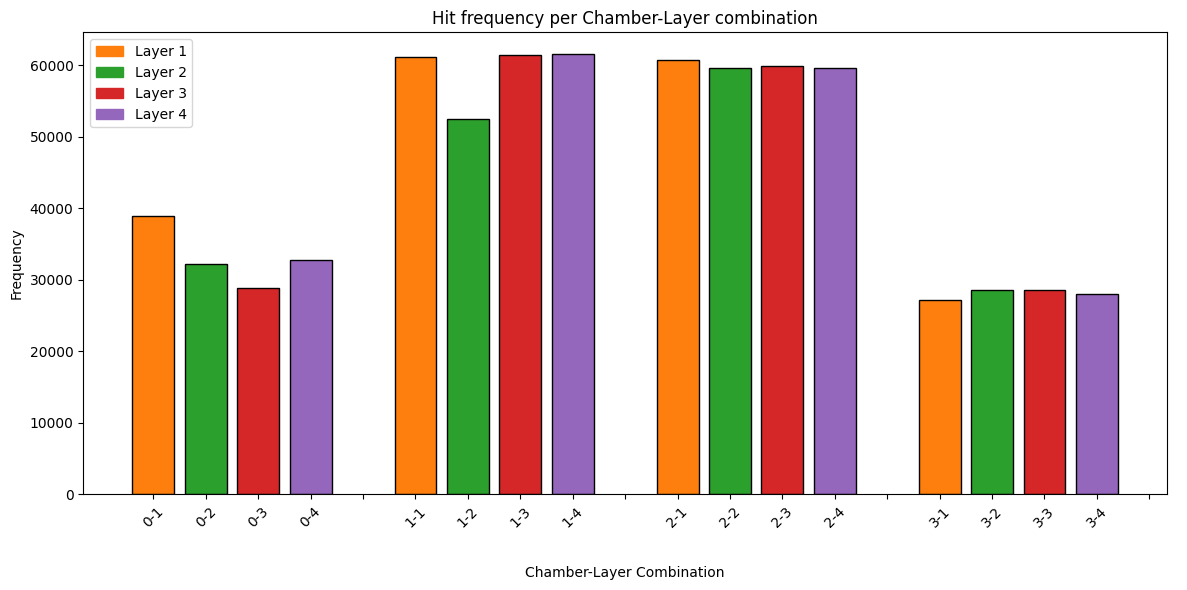

In [16]:
labels = []
colors = []

bars_per_group = 4

for i, row in freqs.iterrows():
    labels.append(f"{row['CHAMBER']}-{row['LAYER']}")
    colors.append(plt.cm.tab10(row['LAYER']))
    
    # Creating spaces between chambers for a better visualization
    if (i+1) % bars_per_group == 0:
        labels.append(' ' * i)
        colors.append('white')

frequencies = np.array(freqs['count'], dtype = float)
frequencies = np.insert(frequencies, np.array([4, 8, 12, 16]), np.nan)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, frequencies, color = colors, edgecolor = 'black', width = 0.8)
ax.set_xlabel('Chamber-Layer Combination')
ax.set_ylabel('Frequency')
ax.set_title('Hit frequency per Chamber-Layer combination')
plt.xticks(rotation=45)
plt.tight_layout()


# Legend
unique_layers  = sorted(freqs['LAYER'].unique())
legend_labels  = [f'Layer {layer}' for layer in unique_layers]
legend_handles = [plt.Rectangle((0,0),1,1, color = plt.cm.tab10(layer)) for layer in unique_layers]
plt.legend(legend_handles, legend_labels, loc = 'upper left')

plt.show()

On average, chambers $1$ and $2$ have more counts than chambers $0$ and $3$. This is probably due to the fact that the formers are placed between the two scintillators, where muon passages are registered, so - considering the flux of muons coming from space - it's more probable for the muons to pass through them while also crossing the scintillators.

This reasoning, however, should only explain the lack of hits in chamber $3$ and not in chamber $0$. We think that the different orientation of the chamber $1$ may cause the registration of some tracks that don't cross any chamber $0$ cell.

We now want to analyze the "frontal" prospective of the experiment. For this purpose we created a function named `get_section()`, which separates each layer into $16$ sections. We expect a higher number of counts in the sections closest to the scintillator.

In [17]:
# Dividing each layer into 16 sections to better study the distribution of the muons 
def get_section(chamber, chan):

    block1 = [i for i in range(0, 64)] 
    block2 = [i for i in range(64, 128)]

    sub_lists1 = [block1[i:i + 4] for i in range(0, len(block1), 4)]
    sub_lists2 = [block2[i:i + 4] for i in range(0, len(block2), 4)]

    
    if chamber == 0 or chamber == 2:
         section = next((index for index, sublist in enumerate(sub_lists1) if chan in sublist), -1)
         
    elif chamber == 1 or chamber == 3:
         section = next((index for index, sublist in enumerate(sub_lists2) if chan in sublist), -1)

    elif chamber == -1:
        section = np.nan

    return(section)

We now plot the histogram of counts per section. Due to the different orientation of the chamber $1$ we will consider also the case where those hits are excluded from the counts.

In [18]:
def view_sections(event, sections, title = 'Counts per section', flag = True):
   
    sections_cleaned = [x if not np.isnan(x) else -2 for x in sections]
    
    # Count occurrences manually
    occurrences = {}
    for section in sections_cleaned:
        if section in occurrences:
            occurrences[section] += 1
        else:
            occurrences[section] = 1
    elements = sorted(occurrences.keys())
    
    counts = [occurrences[element] for element in elements]
   
    # Plotting only the histogram
    if flag == False:
      fig, ax = plt.subplots(1, 1, figsize = (10, 5))
      ax.bar(elements, counts, edgecolor = 'black')
      ax.set_xlabel('Section')
      ax.set_ylabel('Counts')
      ax.set_title(title)
      ax.set_xticks([i for i in range(0, len(elements)-1)])
      ax.set_xlim(-1, len(elements)-1)
      ax.tick_params(axis = 'x', rotation = 45)
      plt.show() 

    # Plotting both the histogram and the schema
    else:
        # Histogram
        fig, ax = plt.subplots(2, 1, figsize=(10, 10))     
        ax[0].bar(elements, counts, edgecolor = 'black')
        ax[0].set_xlabel('Section')
        ax[0].set_ylabel('Counts')
        ax[0].set_title(title)
        ax[0].set_xticks([i for i in range(0, len(elements)-1)])
        ax[0].set_xlim(-1, len(elements)-1)
        ax[0].tick_params(axis = 'x', rotation = 45)

        # Schema

        # Parameters
        w, h = 1, 13/42
        x_rect = np.arange(-8*w, 8*w, w)
        z_rect = np.arange(-2*h, 2*h, h)
        base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
        colors = [to_rgba(c, alpha=0.5) for c in base_colors] 
        scintillator_height = 0.3
        scintillator_y = -3.75*h - scintillator_height/2
        scintillator_x_start = 0.5*w + 7.5 + 0.20
        scintillator_width = 4.5*w - 0.5 - 0.20

        # Drawning
        ax[1].set_xlim(-9*w, 9*w)
        ax[1].set_ylim(-2*h, 2*h)
        counter = 0
        for i in range(4):
            if i % 2 == 0:
                x = x_rect + w/2 + 7
            else:
                x = x_rect + 7
            for j in range(16):
                if counter <= 15:
                   ax[1].add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j], label = f'Section {j}'))
                else:
                   ax[1].add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j]))
                counter += 1

        ax[1].add_patch(Rectangle((scintillator_x_start, scintillator_y), scintillator_width, scintillator_height,
                              lw=2, edgecolor='blue', facecolor='lightblue', alpha=0.5, hatch='/', label = 'Scintillator'))
        ax[1].axis('equal')
        ax[1].set_xticks([i for i in range(16)])
        ax[1].set_title('Experimental apparatus')


        # Legend
        legend = ax[1].legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True, shadow = True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(0.8)
        plt.setp(legend.get_texts(), color = 'black') 
    
        plt.tight_layout()
        plt.show()

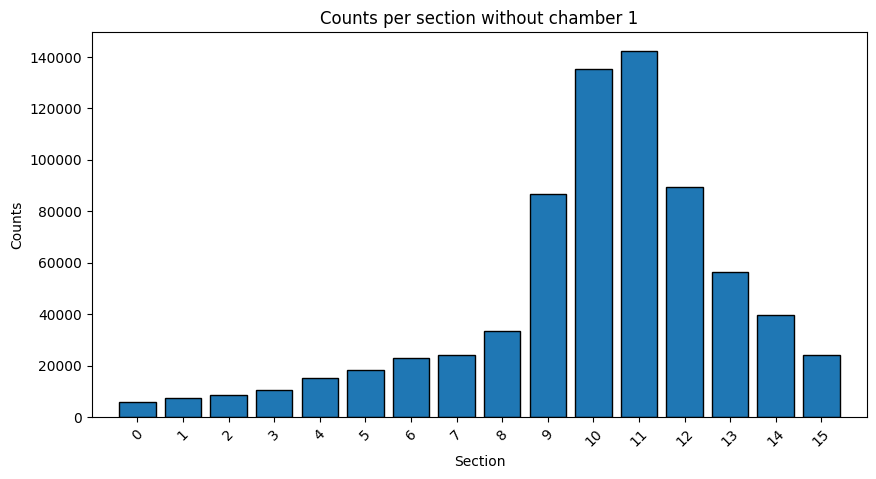

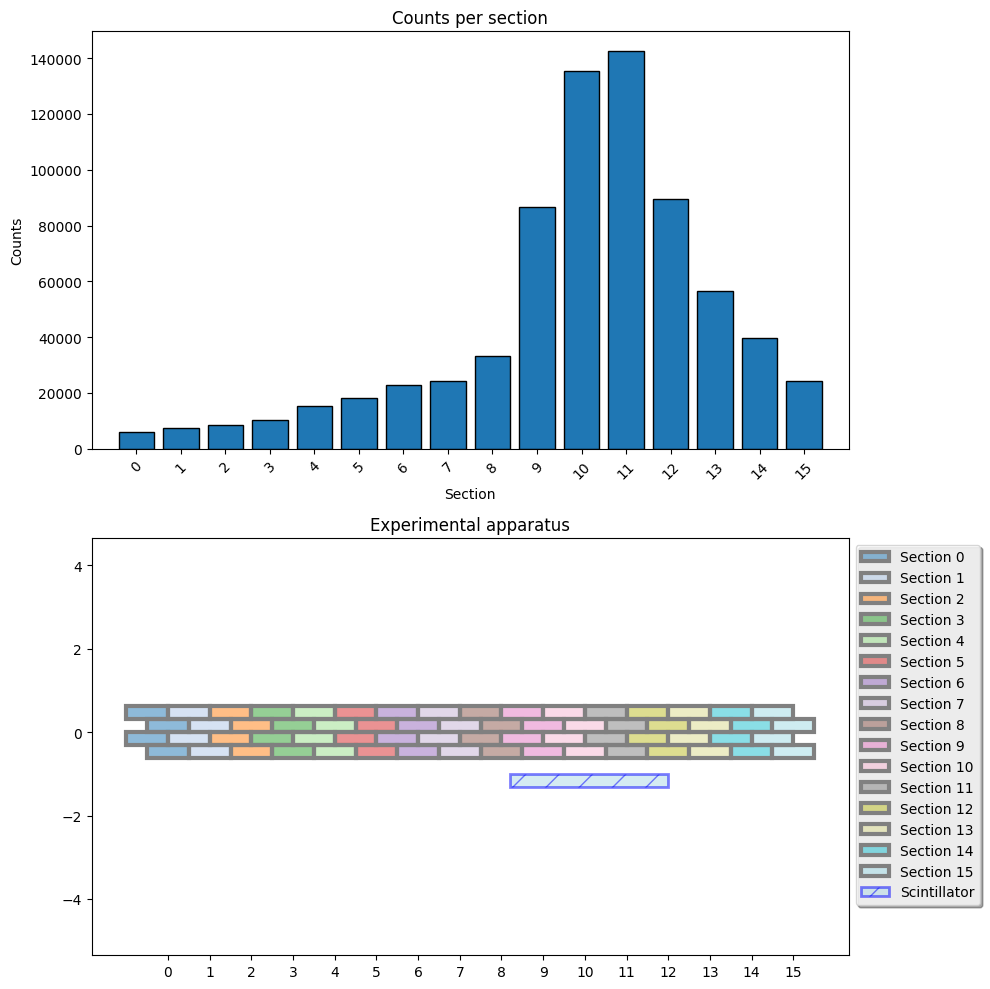

In [19]:
sections = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()
sections = np.array(sections).flatten()

df_wo_chamber1       = df.filter(col('CHAMBER') != 1)
sections_wo_chamber1 = df.rdd.map(lambda row: get_section(row['CHAMBER'], row['CHAN'])).collect()
sections_wo_chamber1 = np.array(sections_wo_chamber1).flatten()

view_sections(df_wo_chamber1, sections_wo_chamber1, title = 'Counts per section without chamber 1', flag = False)
view_sections(df, sections, flag = True)

Results reflect our expectations. Also, it doesn't seem to be a real difference not considering chamber $1$ hits.

## Hit time information

Information about time is provided by three attributes: `ORBIT`, `BX` and `TDC`. We can evaluate the absolute time associated to each hit in nanoseconds using the formula

$$t_{abs} = 25\cdot\left(\texttt{ORBIT} * 3564 + \texttt{BX} + \texttt{TDC}/30\right)$$

In [20]:
df = df.withColumn("T_ABS", 25 * (col("ORBIT") * 3564 + col("BX") + col("TDC") / 30))

In order to compare the time of chamber hits with the time of scintillation events we need to consider the estimated offset.

In [21]:
def remove_offset(chamber): 
      if chamber == 0:
        return(95.0 - 1.1)
      elif chamber == 1:
        return(95.0 + 6.4)
      elif chamber == 2:
        return(95.0 + 0.5)
      elif chamber == 3:
        return(95.0 - 2.6)
      else:
          return(0.0)

remove_offset_udf = udf(remove_offset, DoubleType())

df = df.withColumn("T_ABS", col("T_ABS") + remove_offset_udf(col("CHAMBER")))

Now we have all the temporal information we need.

We can do some physical considerations knowing the geometrical structure of the detector; in fact, each cell has width equal to $42 \ mm$, and each muon passage is revelead via ionization, i. e. an electron that moves inside the cell from the cathode (at the edge) to the anode wire (at the center) with constant velocity $v_{drift}$. Since we know the maximum distance that can be covered by electrons (half of the cell width, $21 \ mm$), and we also know $v_{drift}$, we can evaluate the maximum time for which an hit can be causally connected with a scintillation event:

$$t_{max}=\frac{\frac{w}{2}}{v_{drift}}=\frac{21\cdot10^3 \ \mu m}{53.8 \ \frac{\mu m}{ns}}\simeq390.33 \ ns$$

This means that any hit more than $390 \ ns$ temporally distant cannot be related to any muon transition and we can drop it off.

In [22]:
scints = df.filter(col("SCINT") == 1)\
           .select("ORBIT", col("T_ABS").alias("T_ABS_SCINT"))\

df = df.join(scints, on = "ORBIT", how = "left")\
       .withColumn("T_DIFF", abs_spark(col("T_ABS") - col("T_ABS_SCINT")))\
       .drop("T_ABS_SCINT")

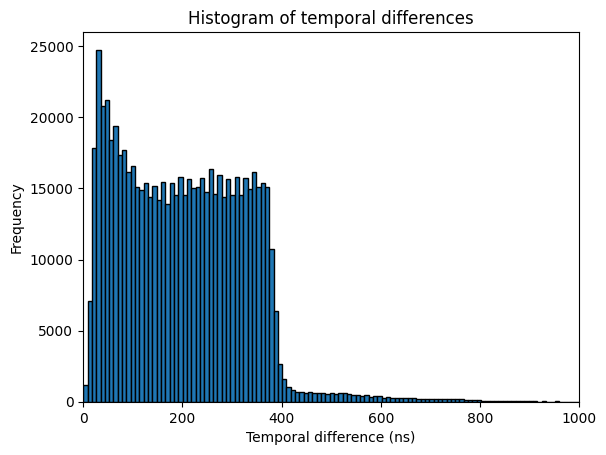

In [23]:
t_diffs = df.filter(col("T_DIFF") != 0)\
            .select("T_DIFF")\
            .toPandas()

plt.hist(t_diffs['T_DIFF'], bins = 10000, edgecolor = 'black')
plt.xlabel('Temporal difference (ns)')
plt.ylabel('Frequency')
plt.title('Histogram of temporal differences')
plt.xlim(0, 1000)
plt.show()

As expected, most number of the temporal differences are inside the $390 \ ns$ range. All the remaining times cannot be associated with a muon detection, hence we descard them.

In [24]:
df = df.filter(col("T_DIFF") <= 390)

From now on we will never use `BX`, `TDC` and `T_ABS` information, so we can free some space deleting those attributes.

In [25]:
df1 = df.drop("BX", "TDC", "T_ABS")

# Having reduced our dataframe, we unpersist the previous one and persist the new one
df.unpersist()
df1 = df1.persist()

Finally, we repeat the histogram of the number of hits per orbit.

In [26]:
n_hits = df1.groupBy('ORBIT')\
           .count()\
           .toPandas()

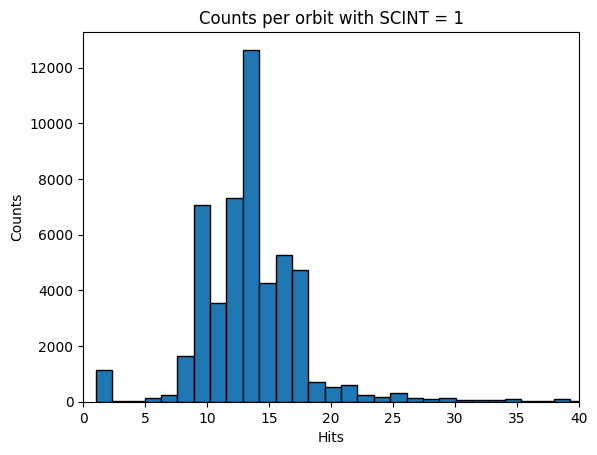

In [27]:
plt.hist(n_hits["count"], bins = 200, edgecolor = 'black')
plt.xlabel('Hits')
plt.ylabel('Counts')
plt.xlim(0, 40)
plt.title('Counts per orbit with SCINT = 1')
plt.show()

Another thing we can observe is the number of hits per single chamber. We expect most of the chambers to have at most four hits.

In [28]:
n_counts = df1.filter(df['CHAMBER'] != 1)\
             .groupBy(['ORBIT', 'CHAMBER'])\
             .count()\
             .toPandas()

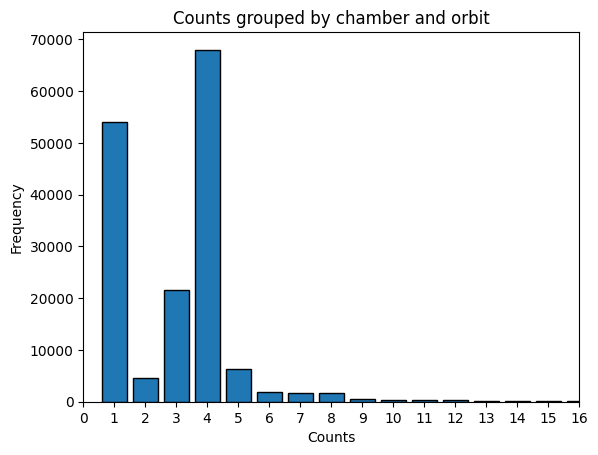

In [29]:
counts = n_counts['count'].value_counts().sort_index()
plt.bar(counts.index, counts.values, edgecolor = 'black')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.xticks(np.arange(17))
plt.xlim([0, 16])
plt.title('Counts grouped by chamber and orbit')
plt.show()

To be more precise, we can investigate which chamber contributes the most to the total number of hit.

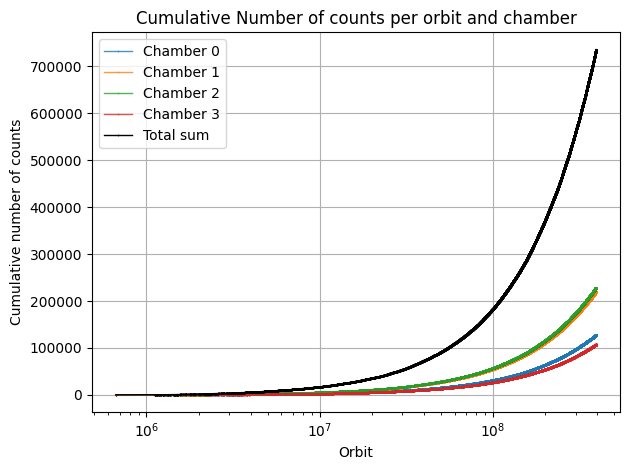

In [30]:
n_chambers_per_orbit_and_chamber = df1.filter(col('CHAMBER') != -1)\
                                     .groupBy('ORBIT', 'CHAMBER')\
                                     .agg(count(col('*')).alias("CHAMBER_COUNT"))\
                                     .orderBy('ORBIT', 'CHAMBER')\
                                     .toPandas()

n_chambers_per_orbit_and_chamber['CUMULATIVE_CHAMBERS'] = n_chambers_per_orbit_and_chamber.groupby('CHAMBER')['CHAMBER_COUNT'].cumsum()
n_hits = n_hits.sort_values(by = 'ORBIT')
n_hits['CUMULATIVE_COUNT'] = n_hits['count'].cumsum()


for chamber in n_chambers_per_orbit_and_chamber['CHAMBER'].unique():
    data_subset = n_chambers_per_orbit_and_chamber[n_chambers_per_orbit_and_chamber['CHAMBER'] == chamber]
    plt.plot(data_subset['ORBIT'], data_subset['CUMULATIVE_CHAMBERS'], marker = '.', markersize = 0.5,  linewidth = 1, alpha = 0.8, label = f'Chamber {chamber}')


plt.plot(n_hits['ORBIT'], n_hits['CUMULATIVE_COUNT'], marker = '.', markersize = 0.5, linewidth = 1, color = 'black', label = 'Total sum')    
plt.title('Cumulative Number of counts per orbit and chamber')
plt.xlabel('Orbit')
plt.ylabel('Cumulative number of counts')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that in many cases chambers $0$ and $3$ are not triggered by the passage of the muon compared to chambers $1$ and $2$. This is something we partially already observed in the spacial prospective paragraph, so our analysis appears to be consistent so far.

This is our cleaned dataset. We still observe orbits where the number of hits is bigger than $16$, hence we choose to drop them off. At the same time, since our goal is to recontruct tracks via interpolation, we can't study cases where the number of points is less than three, so we descard those cases as well.

In [31]:
orbit_counts = df1.groupBy("ORBIT").count()

df1 = df1.join(orbit_counts, on = "ORBIT", how = "inner")\
       .filter((col("count") <= 16) & (col("count") >= 3))\
       .drop("count")

In the analysis that follows we won't consider chamber $1$, since its different orientation is only useful for 3D information, which is something we are not interested in. Hence, we drop every chamber $1$ hit off.

In [32]:
df1 = df1.filter(col('CHAMBER') != 1)

In the analysis that follows, we will consider the cases where each layer of each chamber has at most one hit, so we also need to descard hits on the same layer in the same orbit and the same chamber.

In [33]:
df_counts = df1.groupBy("ORBIT", "CHAMBER", "LAYER")\
              .count()

df_counts = df_counts.filter(df_counts['count'] == 1)

df1 = df1.join(df_counts, on = ["ORBIT", "CHAMBER", "LAYER"], how = "left")\
        .drop("count")

This is our final and cleaned up version of the dataset.

In [34]:
df1.show(10)

+-------+-------+-----+----+----+-----+------------------+
|  ORBIT|CHAMBER|LAYER|CHAN|FPGA|SCINT|            T_DIFF|
+-------+-------+-----+----+----+-----+------------------+
|1135298|      2|    4|  47|   1|    0|              20.5|
|1135298|     -1|   -1| 128|   1|    1|               0.0|
|1135298|      0|    3|  21|   0|    0|31.399993896484375|
|1135298|      0|    1|  20|   0|    0| 174.7333221435547|
|1135298|      0|    2|  22|   0|    0| 291.3999786376953|
|1135298|      2|    2|  46|   1|    0|154.66665649414062|
|1135298|      2|    1|  48|   1|    0|167.99998474121094|
|1135298|      2|    3|  49|   1|    0| 321.3333282470703|
|1135298|      0|    4|  19|   0|    0| 326.3999786376953|
|1297227|      2|    2|  46|   1|    0| 73.83332824707031|
+-------+-------+-----+----+----+-----+------------------+
only showing top 10 rows



# Track muons reconstruction

## Spatial coordinates

Now that we have reconstructed the $\Delta t$ time for each hit, we can obtain the position of the hit of the particle through a single cell, according to the following formula:

$$ x = v_{drift} \cdot (t_{hit} - t_0) = v_{drift} \cdot \Delta t $$

where

$$v_{drift} = 53.8 \ \frac{\mu m}{ns} = 53.8 \cdot 10^{-3} \frac{mm}{ns}$$

In [35]:
v_drift = 53.8 * 10**(-3) 
df1 = df1.withColumn('X', col('T_DIFF') * v_drift)

df1.show(10)

+-------+-------+-----+----+----+-----+------------------+------------------+
|  ORBIT|CHAMBER|LAYER|CHAN|FPGA|SCINT|            T_DIFF|                 X|
+-------+-------+-----+----+----+-----+------------------+------------------+
|1135298|      2|    4|  47|   1|    0|              20.5|            1.1029|
|1135298|     -1|   -1| 128|   1|    1|               0.0|               0.0|
|1135298|      0|    3|  21|   0|    0|31.399993896484375|1.6893196716308594|
|1135298|      0|    1|  20|   0|    0| 174.7333221435547| 9.400652731323243|
|1135298|      0|    2|  22|   0|    0| 291.3999786376953|15.677318850708009|
|1135298|      2|    2|  46|   1|    0|154.66665649414062| 8.321066119384765|
|1135298|      2|    1|  48|   1|    0|167.99998474121094| 9.038399179077148|
|1135298|      2|    3|  49|   1|    0| 321.3333282470703|17.287733059692382|
|1135298|      0|    4|  19|   0|    0| 326.3999786376953|17.560318850708008|
|1297227|      2|    2|  46|   1|    0| 73.83332824707031|3.9722

We can inspect the distribution of these distances.

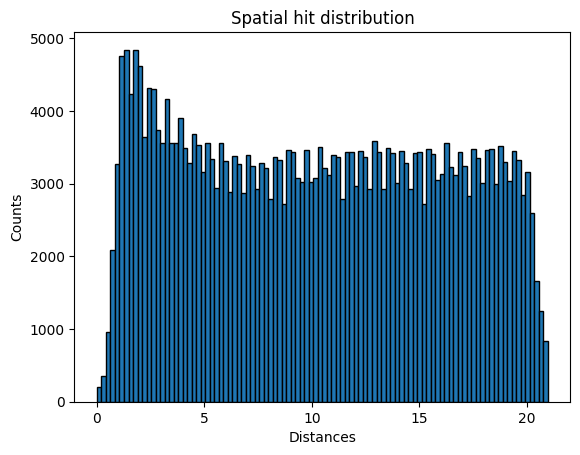

In [36]:
data = df1.filter(col("SCINT") == 0)\
         .select('X')\
         .rdd.flatMap(lambda x: x)\
         .collect()

plt.hist(data, bins = 100, edgecolor = 'black')
plt.title('Spatial hit distribution')
plt.xlabel('Distances')
plt.ylabel('Counts')
plt.show()

Of course, all distances are inside the $21 \ mm$ limit, because of the filtering we computed above. Anyway, all values tend to distribuite uniformly, with a slight peak towards the smaller values.

Also, as explained in the text, we are facing a left-right ambiguity, since time information alone doesn't carry the information about the position with respect to the anode.

We now want to create a function that takes the values of `X`, `CHAN`, `CHAMBER` and `LAYER` for each row and returns the coordinate $x$ with respect to the same frame of reference indicated in the guidelines.

We know that

* for chamber 0 and 2 CHAN is in $[0, 63]$
* for chamber 3 CHAN is in $[64, 127]$

We represent each cell inside the channel by encoding its index inside a matrix. Since the center of the reference is placed eight positions from the left border, the schema is as it follows:


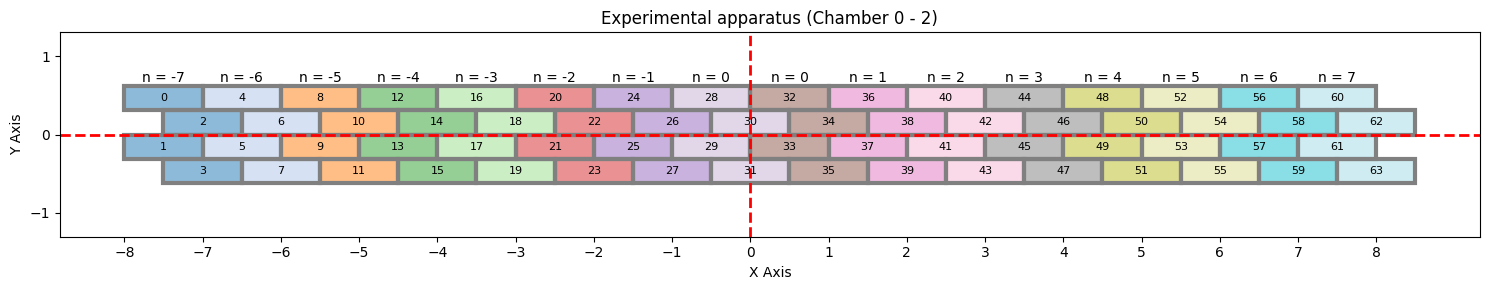

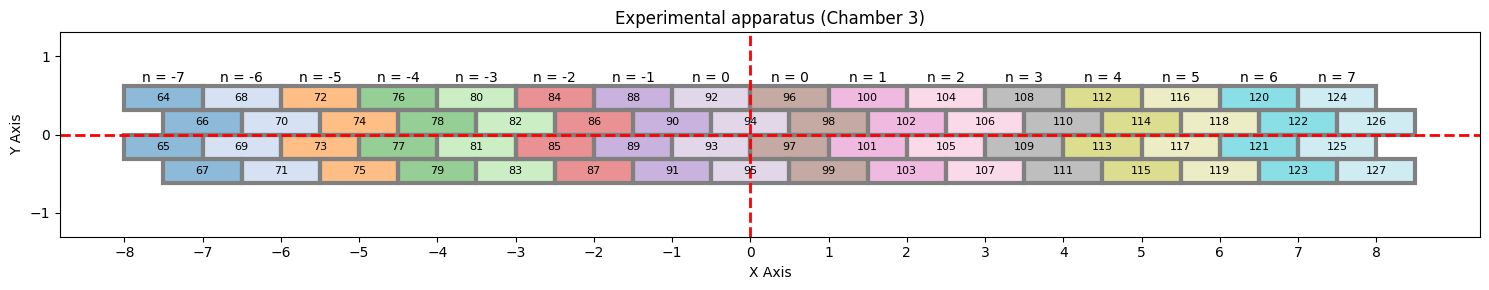

In [37]:
# Parameters
w, h = 1, 13/42
x_rect = np.arange(-8*w, 8*w, w)
z_rect = np.arange(-2*h, 2*h, h)
base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
colors = [to_rgba(c, alpha=0.5) for c in base_colors]
scintillator_height = 0.3
scintillator_y = -3.75*h - scintillator_height/2
scintillator_x_start = 0.5*w + 0.20
scintillator_width = 4.5*w - 0.5 - 0.20

titles = ['Experimental apparatus (Chamber 0 - 2)', 'Experimental apparatus (Chamber 3)']

indeces = [-7, -6, -5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5, 6, 7]

for idx, start in enumerate([0, 64]):
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(-2*h, 2*h)

    cell_n_type02 = np.zeros((4, 16), dtype=int)
    for k in range(16):
        cell_n_type02[0, k] = 4 * k + 3 + start
        cell_n_type02[1, k] = 4 * k + 1 + start
        cell_n_type02[2, k] = 4 * k + 2 + start
        cell_n_type02[3, k] = 4 * k + start
        
    for i in range(4):
        if i % 2 == 0:
            x = x_rect + w/2
        else:
            x = x_rect
        for j in range(16):
            counter = cell_n_type02[i, j]
            ax.add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor=colors[j]))
            ax.text(x[j] + w/2, z_rect[i] + h/2, str(counter), ha='center', va='center', fontsize=8, color='black')

    for j, n_index in enumerate(indeces):
        ax.text(x_rect[j] + w/2, 2*h + 0.1, f'n = {n_index}', ha='center', va='center', fontsize=10, color='black')

    ax.axhline(y=0, color='red', linewidth=2, linestyle='--') 
    ax.axvline(x=0, color='red', linewidth=2, linestyle = '--') 

    ax.axis('equal')
    ax.set_xticks(np.arange(-8, 9, 1))
    ax.set_yticks(np.arange(-2, 3, 1))
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_title(titles[idx])

    plt.tight_layout()
    plt.show()

We're gonna use an index to refer to each cell with respect to $x=0$:

* channel 32 is counted as the first cell, so it will have index $n=0$;  same for channels 34, 33, 35 (they have the same $x$ information, plus a shift on layer 1 and 3)
* channel 36 will have `index = int( chan / 4 ) - 8 = 1`
* channel 40 will have `index = int( chan / 4 ) - 8 = 2`
* ...and so on

Indicating the index with $n$, the $x$ in this reference will be:

$$x_{left} = [ (n + 0.5)\cdot w - x ] + shift \hspace{1 cm} x_{right} = [ (n + 0.5)\cdot w + x ] + shift$$

where $w$ is the width of the cell, $x$ is the measure with respect to the center of the cell and $shift$ is the offset of layers 1 and 3 equal to $w/2$.

The situation is similar for chamber 3, where CHAN is in $[64, 127]$.

In [38]:
# Function that evaluates both coordinates for each hit
def left_or_right(x, chamber, chan, layer):
    w = 42  # mm, width of the cell
    
    shift = w / 2 if layer == 2 or layer == 4 else 0  # Applying a w/2 shift on layers 1 and 3 given the geometry, else 0 
    
    if chamber == 0 or chamber == 2:
        n = int(chan / 4) - 8 + 1 if chan <= 31 else int(chan / 4) - 8 
        cell_index = n - 0.5 if chan <= 31 else n + 0.5 #-2.5 chan 21
        cell_center = cell_index * w # - 2.5 * w
        return [shift + cell_center - x, shift + cell_center + x]

        
    elif chamber == 3:
        n = int(chan / 4) - 24 + 1 if chan <= 96 else int(chan / 4) - 24
        cell_index = n - 0.5 if chan <= 96 else n + 0.5
        cell_center = cell_index * w
        return [shift + cell_center - x, shift + cell_center + x]
    
    else:
        return [float('nan'), float('nan')]
        
# Register UDF
left_or_right_udf = udf(left_or_right, ArrayType(FloatType()))

# Apply UDF to DataFrame
df1 = df1.withColumn("X_COORDS", left_or_right_udf(df1['X'], df1['CHAMBER'], df1['CHAN'], df1['LAYER']))
df1 = df1.withColumn("X_LEFT", df1['X_COORDS'].getItem(0))
df1 = df1.withColumn("X_RIGHT", df1['X_COORDS'].getItem(1))
df1 = df1.drop("X").drop("T_DIFF").drop("X_COORDS")

df1.show(10)

+-------+-------+-----+----+----+-----+----------+----------+
|  ORBIT|CHAMBER|LAYER|CHAN|FPGA|SCINT|    X_LEFT|   X_RIGHT|
+-------+-------+-----+----+----+-----+----------+----------+
|1135298|      2|    4|  47|   1|    0|  166.8971|  169.1029|
|1135298|     -1|   -1| 128|   1|    1|       NaN|       NaN|
|1135298|      0|    3|  21|   0|    0|-106.68932|-103.31068|
|1135298|      0|    1|  20|   0|    0|-114.40065| -95.59935|
|1135298|      0|    2|  22|   0|    0| -99.67732| -68.32268|
|1135298|      2|    2|  46|   1|    0| 159.67894| 176.32106|
|1135298|      2|    1|  48|   1|    0|  179.9616|  198.0384|
|1135298|      2|    3|  49|   1|    0| 171.71227| 206.28773|
|1135298|      0|    4|  19|   0|    0|-143.56032|-108.43968|
|1297227|      2|    2|  46|   1|    0| 164.02777| 171.97223|
+-------+-------+-----+----+----+-----+----------+----------+
only showing top 10 rows



We can observe how the hits are distributed with respect to these coordinates.

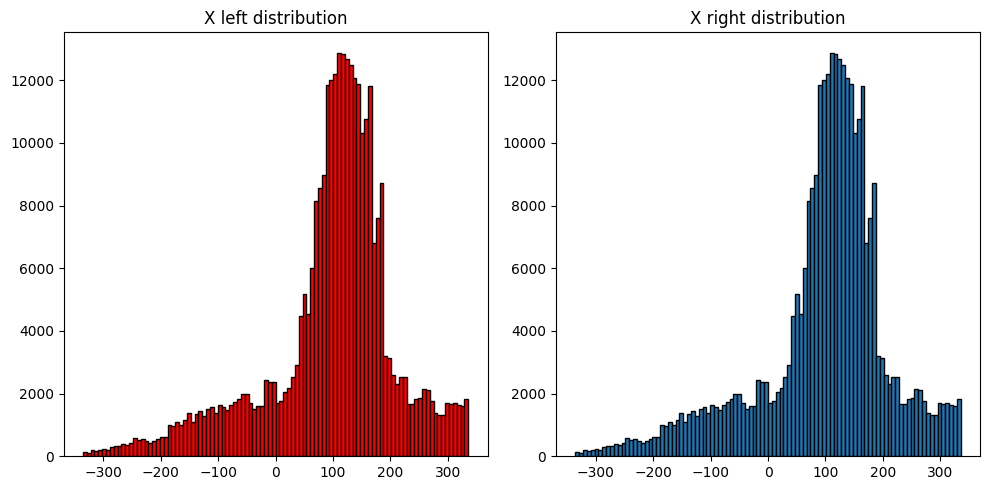

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

x_left_counts = df1.select('X_LEFT').rdd.flatMap(lambda x: x).collect()
x_right_counts = df1.select('X_LEFT').rdd.flatMap(lambda x: x).collect()

axes[0].hist(x_left_counts, bins = 100, edgecolor = 'black', label = 'X LEFT', color = 'red')
axes[0].set_title('X left distribution')

axes[1].hist(x_right_counts, bins = 100, edgecolor = 'black', label = 'X RIGHT')
axes[1].set_title('X right distribution')

plt.tight_layout()
plt.show()

Clearly, we don't see much differences from the frontal space prospective, since the scintillators are placed around sectors $9-12$, confirming the bias on the right.

We still miss the $z$ coordinate; we can evaluate $z$ by summing the `shift_chamber` given by the text and the height with respect to the chamber frame of reference, that we can call `shift_layer`:

```python
shift_layer = {
        1: 3/2 * h,
        2: 1/2 * h,
        3: -1/2 * h,
        4: -3/2 * h
}
```

where $h$ is the height of the cell ($13 \ mm$).

In [40]:
def height(chamber, layer):
    h = 13 # mm, height of the cell

    local_level  = [1.5, 0.5, -0.5, -1.5]
    global_level = [219.8, 977.3, 1035.6, 1819.8]

    return ((local_level[(layer - 1)] * h) + global_level[chamber])

height_udf = udf(height, FloatType())
df1 = df1.withColumn("Z", height_udf(col("CHAMBER"), col("LAYER")))
df1 = df1.drop("CHAN").drop("FPGA")


df1.show(10)

+-------+-------+-----+-----+----------+----------+------+
|  ORBIT|CHAMBER|LAYER|SCINT|    X_LEFT|   X_RIGHT|     Z|
+-------+-------+-----+-----+----------+----------+------+
|1135298|      2|    4|    0|  166.8971|  169.1029|1016.1|
|1135298|     -1|   -1|    1|       NaN|       NaN|1813.3|
|1135298|      0|    3|    0|-106.68932|-103.31068| 213.3|
|1135298|      0|    1|    0|-114.40065| -95.59935| 239.3|
|1135298|      0|    2|    0| -99.67732| -68.32268| 226.3|
|1135298|      2|    2|    0| 159.67894| 176.32106|1042.1|
|1135298|      2|    1|    0|  179.9616|  198.0384|1055.1|
|1135298|      2|    3|    0| 171.71227| 206.28773|1029.1|
|1135298|      0|    4|    0|-143.56032|-108.43968| 200.3|
|1297227|      2|    2|    0| 164.02777| 171.97223|1042.1|
+-------+-------+-----+-----+----------+----------+------+
only showing top 10 rows



Now we have all the information we need to perform linear fits.

## Local tracks

For local track reconstruction we need to focus on hits inside the same orbit and chamber. We will not consider events with only one hit for obvious reasons, as well as with only two hits, since two point are crossed by one and only one line and therefore no linear fit is actually possible.

The first thing we want to do is to obtain each possible combination of (`X_LEFT`,`X_RIGHT`) considering the three or four hits; hence, we are going to work with only $2^3$ or $2^4$ combinations in each event. Having these combinations, we need to perform a linear fit for each combination, observing which one of them suits better, i. e. has the least residual value (evaluated with the least square method).

Since we can't use loops (as suggested by the guidelines) we will use the function `np.linalg.lstsq`, which can take more sets of coordinates and returns the results for each one of them. Still, there is an issue: this function takes more than one set of coordinates only in the $z$-axis, since they correspond to the costant values of the set of equations, but in our case the different set of coordinates are placed in the $x$-axis. In order to solve this issue we are going to compute the cofficients and the residuals inverting the axes; in the end, we should find something like

$$x=mz+q$$

that gives us the line

$$z=\frac{1}{m}x-\frac{q}{m}=m'x+q' \hspace{0.85cm} \text{where} \hspace{0.4cm} \begin{cases}m'=\frac{1}{m}\\ q'=-\frac{q}{m}\end{cases}$$

We calculate the fit for each combination and select the one with the lowest residual value.

In [ ]:
def local_fit(group):
    if len(group) == 3 or len(group) == 4:
        # Get all the (X_LEFT, X_RIGHT) combinations
        pairs  = list(zip(group['X_LEFT'], group['X_RIGHT']))
        combos = list(itertools.product(*pairs))

        # Creating the z vector
        z = group['Z'].tolist()

        # Creating the correct matrices for the fit
        combos_matrix = np.array(combos)
        Z = np.vstack([z, np.ones(len(z))]).T

        # Fit
        coeff, residuals = np.linalg.lstsq(Z, combos_matrix.T, rcond = None)[:2]

        if len(residuals) == 0:
           group['X_TRUE'] = 0
           group['M'] = 0
           group['Q'] = 0
           group['RSE'] = 1e7 # In order to remove it from the dataset
              
        else:
          # Getting the best fit
          minimum_index = np.argmin(residuals)

          # Best values
          rse = residuals[minimum_index]
          m = 1 / coeff[0][minimum_index]
          q = - coeff[1][minimum_index] / coeff[0][minimum_index]

          # New attributes
          group['X_TRUE'] = combos_matrix[minimum_index]
          group['M'] = m
          group['Q'] = q
          group['RSE'] = rse

    return group  



df_local = df1.filter(col('SCINT') != 1).toPandas()
df_local = df_local.groupby(['ORBIT', 'CHAMBER']).apply(lambda group: local_fit(group))
df_local = df_local[['LAYER', 'ORBIT', 'CHAMBER', 'Z', 'X_TRUE', 'M', 'Q', 'RSE', 'X_LEFT', 'X_RIGHT']].reset_index(drop = True)

df_local = df_local.groupby(['ORBIT', 'CHAMBER']).agg({
               'Z': list,
               'X_TRUE': list,
               'X_LEFT': list, 
               'X_RIGHT': list,
               'M': 'first',
               'Q': 'first', 
               'RSE': 'first',
               'LAYER': list
         }).reset_index()

df1.unpersist() # Since we won't use it anymore

We can explore how the `RSE` scales with respect to the fit, from the best one to the worst one.

In [ ]:
# We sort the dataframe with respect to the RSE (ascending order)
df_local = df_local.sort_values(by = 'RSE', ascending = True).reset_index(drop = True)

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(df_local.index, df_local['RSE'], linestyle = '-')
plt.title('RSE values')
plt.xlabel('Index')
plt.ylabel('RSE (log)')
plt.yscale('log')
plt.grid(True)
plt.show()

The trend tends to grow quite rapidly in the first part, stabilizing in the middle part and exploding again in the final part. Because of this, one reasonable choise for a threshold above which dropping off the fits could be $0.5$, since it includes most of the fits and is placed before the final explosion of the trend.

In [ ]:
df_local = df_local[df_local['RSE'] <= 0.5]
df_local

We now create a function able to plot the fits, highlighting the best combination of coordinates.

In [ ]:
def plot_event(event, flag=True):
    # event will be a row in our dataframe, we should change it 
    
    w, h = 1, 13/42
    
    chamber, orbit, layer = int(event['CHAMBER']), int(event['ORBIT']), event['LAYER']
    Z_list, X_list = event['Z'], event['X_TRUE']
    X_LEFT, X_RIGHT = event['X_LEFT'], event['X_RIGHT']
    m, q, rse = event['M'], event['Q'], event['RSE']
    
    set_x_true = set(X_list)
    
    non_common_elements = []

    # Adding elements of (X_LEFT, X_RIGHT) not in X_TRUE
    for j, k in zip(X_LEFT, X_RIGHT):
        if j not in set_x_true:
            non_common_elements.append(j)
        else:
            non_common_elements.append(k)

    X_list = [i / 42 for i in X_list]
    non_common_elements = [i / 42 for i in non_common_elements]

    # Offsets defined by layers and chamber 
    offset_layer = [2*h, h, -h, -2*h]
    offset_z = [219.8, 977.3, 1035.6, 1819.8]
    offi_z = offset_z[chamber]
    
    Z_list = [(zi - offi_z - offi_layer) / 42 for zi, offi_layer in zip(Z_list, offset_layer)]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))  

    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h)
    base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
    colors = [to_rgba(c, alpha=0.5) for c in base_colors]
    scintillator_height = 0.3
    scintillator_y = -3.75*h - scintillator_height/2
    scintillator_x_start = 0.5*w + 7.5 + 0.20
    scintillator_width = 4.5*w - 0.5 - 0.20

    ax.set_xlim(-9*w, 9*w)
    ax.set_ylim(-2*h, 2*h)

    for i in range(4):
        if i % 2 == 0:
            x = x_rect + w/2 
        else:
            x = x_rect
        for j in range(16):
            ax.add_patch(Rectangle((x[j], z_rect[i]), w, h, lw=3, edgecolor='gray', facecolor='white'))

    
    y_offset = min(Z_list) / 42
    adj_m = m
    adj_q = (q - offi_z - y_offset) / 42

    
    if m > 50:
        x_min, x_max = min(X_list) - 1 / 42, max(X_list) + 1 / 42 
    else:
        x_min, x_max = min(X_list) - 1 / 42 * 12, max(X_list) + 1 / 42 * 12
        
    y_min_line = adj_m * x_min + adj_q
    y_max_line = adj_m * x_max + adj_q
    
    ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'blue', linestyle='-', lw=1, label = 'Fit reconstruction')  # extended blue line
    ax.plot(X_list, Z_list, 'rx', label = 'True hits', linestyle = 'none')

    ax.plot(non_common_elements, Z_list, color = 'black', marker = '*', linestyle = 'none', label = 'Other combination')
    ax.legend()
    
    ax.axis('equal')
    ax.set_xticks([i for i in range(-8, 9)])
    ax.set_title(f'Local fit reconstruction in orbit {orbit} and chamber {chamber} (RSE = {rse})')

    plt.tight_layout()
    plt.show()

We show the best three local fit followed by the worst three (considering that we cut off all fits above $RSE=0.5$).

In [ ]:
for i in [0, 1, 2, -3, -2, -1]:
    plot_event(df_local.iloc[i])

## Global tracks

Having selected the correct $x$ coordinate for each hit we can try to extend the fits to all the chambers. We use the `numpy.linalg.lstsq` also in this case, with the only difference that we don't need to consider different combinations since we have the `X_TRUE` values.

In [ ]:
def global_fit(group):
    if group['CHAMBER'].nunique() == 2 or group['CHAMBER'].nunique() == 3:
        x_global = [x for x in group['X_TRUE']]
        z_global = [z for z in group['Z']]
        
        x_flat = np.array(list(itertools.chain(*x_global)))
        z_flat = np.array(list(itertools.chain(*z_global)))

        A = np.column_stack((x_flat, np.ones(len(x_flat))))

        coeff, residuals = np.linalg.lstsq(A, z_flat.T, rcond = None)[:2]

        group['X_GLOBAL']   = x_global
        group['Z_GLOBAL']   = z_global
        group['M_GLOBAL']   = coeff[0]
        group['Q_GLOBAL']   = coeff[1]
        group['RSE_GLOBAL'] = residuals[0]

        group = group[['ORBIT', 'CHAMBER', 'LAYER', 'X_GLOBAL', 'Z_GLOBAL', 'M_GLOBAL', 'Q_GLOBAL', 'RSE_GLOBAL', 'M', 'Q']]

        return group
        


df_global = df_local.groupby("ORBIT").apply(global_fit).reset_index(drop = True)

df_global = df_global.groupby(['ORBIT']).agg({
                                 'CHAMBER': list,
                                 'LAYER': list,
                                 'X_GLOBAL': list,
                                 'Z_GLOBAL': list, 
                                 'M_GLOBAL': 'first',
                                 'Q_GLOBAL': 'first',
                                 'RSE_GLOBAL': 'first',
                                 'M': list,
                                 'Q': list
                              }).reset_index()

df_global = df_global.rename(columns = {'M': 'M_LOCALS', 'Q': 'Q_LOCALS'})

df_global.head(10)

All the cases where there are not chamber $2$ hits cannot be considered, since a global track needs to pass through chamber $2$ for the geometrical structure of the apparatus.

In [ ]:
df_global = df_global[df_global['CHAMBER'].apply(lambda x: 2 in x)]

To select a threshold, we plot the trend of the error value also in this case.

In [ ]:
df_global = df_global.sort_values(by = 'RSE_GLOBAL', ascending = True).reset_index(drop = True)

plt.figure(figsize = (10, 6))
plt.plot(df_global.index, df_global['RSE_GLOBAL'], linestyle = '-')
plt.title('RSE values')
plt.xlabel('Index')
plt.ylabel('RSE (log)')
plt.yscale('log')
plt.grid(True)
plt.show()

The trend resembles the one in the local fits, but more curved upwards. Of course, we cannot select a threshold value that is too big. Considering half of the width the cell as a coarse measure of the resolution, we choose an `RSE` threshold equal to $21$.

In [ ]:
df_global = df_global[df_global['RSE_GLOBAL'] <= 21]

We now plot the best three fit and the worst three.

In [ ]:
def plot_glob(event):

    fig, ax = plt.subplots(1, 1, figsize = (10, 15))
    factor_y = 10
    w, h = 1, 13/42 * 3 
    
    chambers, orbit, layers = event['CHAMBER'], event['ORBIT'], event['LAYER']
    Z_list, X_list = event['Z_GLOBAL'], event['X_GLOBAL']
    m, q, rse = event['M_GLOBAL'], event['Q_GLOBAL'], event['RSE_GLOBAL']
    ms, qs = event['M_LOCALS'], event['Q_LOCALS']

    # Defining an offset by layer for each chamber
    offset_layer = [2*h, h, -h, -2*h]
    
    offset_ch_z = [219.8, 0, 1035.6, 1819.8]
    
    xes, zes = [], []
    xline, yline = [], []

    # Now considering the chamber
    for i in range(len(chambers)):
        chamber = chambers[i]
        
        n_hits = len(Z_list[i]) # Number of hits in that chamber 
        
        offi_z = offset_ch_z[chamber]
        Z = Z_list[i]
        X = X_list[i]

        layer = layers[i]

        X_converted = [i / 42 for i in X]
        Z_converted = [(i - offset_layer[index - 1]) / 14 for i, index in zip(Z, layer)]

        xes.append(X_converted), zes.append(Z_converted)

        # ---------- Plotting local fit -------------- #
        x_min, x_max = min(X_converted) - 0.5, max(X_converted) + 0.5
        mi = 3 * ms[i]
        qi = qs[i] / 14
        
        y_min_line = mi * x_min + qi
        y_max_line = mi * x_max + qi
       
        if i == 1:
            ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'darkgreen', linestyle='--', lw=1, label = 'Local fit reconstruction') 
        else: 
            ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'darkgreen', linestyle='--', lw=1)
            
    xes, zes = list(itertools.chain.from_iterable(xes)), list(itertools.chain.from_iterable(zes))
    

    
    y_offset = min(zes) 
    adj_m = 3 * m
    adj_q = (q )/ 14

    
    x_min, x_max = min(xes) - 0.5, max(xes) + 0.5
    y_min_line = adj_m * x_min + adj_q 
    y_max_line = adj_m * x_max + adj_q
                
    ax.plot([x_min, x_max], [y_min_line, y_max_line], color = 'blue', linestyle = ':', lw = 1, label = 'Global fit reconstruction') 
    ax.plot(xes, zes, color = 'red', marker = 'x', label = 'Hit', linestyle = 'none')


    x_rect = np.arange(-8*w, 8*w, w)
    z_rect = np.arange(-2*h, 2*h, h)
    base_colors = plt.cm.tab20(np.linspace(0, 1, 16))
    colors = [to_rgba(c, alpha=0.5) for c in base_colors]
    scintillator_height = 0.3
    scintillator_y = -3.75*h - scintillator_height/2
    scintillator_x_start = 0.5*w + 7.5 + 0.20
    scintillator_width = 4.5*w - 0.5 - 0.20

    ax.set_xlim(-8.5, 9)
    ax.set_ylim(0, 150)  
 
    
    for k in range(4):
        offset_y = offset_ch_z[k] / 14 # Compute the vertical offset for each repetition

        for i in range(4):

            # No plot for chamber 1
            if k == 1: 
               break 
            if i % 2 == 0:
                x = x_rect + w/2 
            else:
                x = x_rect
            for j in range(16):
                ax.add_patch(Rectangle((x[j], z_rect[i] + offset_y), w, h, lw = 3, edgecolor = 'gray', facecolor = 'white'))

            text_x = -7 # posizione del testo 
            text_y = offset_y + 4
            ax.text(text_x, text_y, f'Chamber {k}', ha = 'center', va = 'center')

    if len(chambers) == 2:
         plt.title(f'Hit collected in orbit {orbit} and chambers: {sorted(chambers)[0]}, {sorted(chambers)[1]} (RSE: {rse:.2f})')
    else:
        plt.title(f'Hit collected in orbit {orbit} and chambers {sorted(chambers)[0]}, {sorted(chambers)[1]}, {sorted(chambers)[2]} (RSE: {rse:.2f})')
    ax.legend()    
    plt.tight_layout()
    plt.show()

In [ ]:
for i in [0, 1, 2, -3, -2, -1]:
    plot_glob(df_global.iloc[i])

We have observed that in most of the cases the reconstructed track crosses only two chambers in the apparatus. Even though in some cases the slope of the straight line is such that not all the chambers are affected, we also observe other cases where, according to the fit, the muon should pass through all the three detectors. 

Let's see the number of cases in which three chambers registered the passage of a muon in the same orbit with respect to the total.

In [ ]:
n_3_chambers = df_global[df_global['CHAMBER'].str.len() == 3].size
Rate = n_3_chambers / df_global.size * 100

print(f'Rate of 3 chambers:  {Rate:.2f} %')

## Detector angular resolution

As suggested by the guidelines, in order to provide an estimate of the angular resolution of the detector we can inspect the angular difference between the local fit in the chamber $2$ and the global fit for the same event. We expect those differences to distribute as a normal curve around zero (assuming there are no bias for the left or for the right).

In [ ]:
df_angles = pd.merge(df_local[df_local['CHAMBER'] == 2], df_global, on = 'ORBIT')[['ORBIT', 'M', 'M_GLOBAL']]

df_angles['ANGLE']        = df_angles['M'].apply(np.arctan)
df_angles['ANGLE_GLOBAL'] = df_angles['M_GLOBAL'].apply(np.arctan)

df_angles = df_angles.drop(columns = ['M', 'M_GLOBAL'])

df_angles['ANGLE_DIFF'] = (df_angles['ANGLE'] - df_angles['ANGLE_GLOBAL']) * 1000

df_angles

Let's make a gaussian fit with the function `stats.norm.fit()` from the `scipy` package.

In [ ]:
mu, s = stats.norm.fit(df_angles['ANGLE_DIFF'])
p = stats.norm.pdf(np.linspace(-60, 60, 1000), mu, s)

plt.figure(figsize = (10, 6))
plt.hist(df_angles['ANGLE_DIFF'], bins = 25, edgecolor = 'black', alpha = 0.7, density = True)
plt.title('Distribution of the differences of angles')
plt.xlabel('Difference of angles (milli-radians)')
plt.ylabel('Frequency')
plt.xlim(-60, 60)

plt.plot(np.linspace(-60, 60, 1000), p, 'k', label = 'Gaussian fit')
print(f"Mean = {mu}")
print(f"Standard deviation = {s}")

plt.grid(True)
plt.legend()
plt.show()

Data follows what expected. Of course, we cannot be very accurate since we miss some valuable information (error on the chamber hit time, error on the scintillator hit time and so on), but we can say that the angular resolution is strongly related to the standard deviation of the curve that fits our histogram. Hence, our estimated angular resolution $\sigma\simeq11.43 \ mrad$, which corresponds to $\sim0.65°$.

In [ ]:
sc.stop()
spark.stop()